# Models: XGBoost & LightGBM 
**Team**: Renaissance Technologies  
**Purpose**: Production-ready refactored code with utility functions


## 1. Setup and Utility Functions

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import json
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"  XGBoost version: {xgb.__version__}")
print(f"  LightGBM version: {lgb.__version__}")

  XGBoost version: 3.0.1
  LightGBM version: 4.6.0


In [ ]:
# UTILITY FUNCTIONS MODULE


def evaluate_model(model, X_train, X_test, y_train, y_test, model_name='Model'):
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]
    test_pred = model.predict(X_test)
    
    train_auc = roc_auc_score(y_train, train_proba)
    test_auc = roc_auc_score(y_test, test_proba)
    train_pr = average_precision_score(y_train, train_proba)
    test_pr = average_precision_score(y_test, test_proba)
    
    cm = confusion_matrix(y_test, test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return {
        'model_name': model_name,
        'train_proba': train_proba,
        'test_proba': test_proba,
        'test_pred': test_pred,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'train_pr': train_pr,
        'test_pr': test_pr,
        'overfit_gap': abs(train_auc - test_auc),
        'confusion_matrix': cm,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    }


def print_model_metrics(results):
    r = results
    print(f"\n{r['model_name']} Performance:")
    print("="*70)
    print(f"  Train ROC-AUC: {r['train_auc']:.4f}")
    print(f"  Test ROC-AUC:  {r['test_auc']:.4f}")
    print(f"  Test PR-AUC:   {r['test_pr']:.4f}")
    print(f"  Overfit Gap:   {r['overfit_gap']:.4f}")
    print(f"\n  Confusion Matrix: TP={r['tp']:,} | FP={r['fp']:,} | FN={r['fn']:,} | TN={r['tn']:,}")


def compare_models_table(results_dict):
    comparison = []
    for name, r in results_dict.items():
        comparison.append({
            'Model': name,
            'Train_AUC': f"{r['train_auc']:.4f}",
            'Test_AUC': f"{r['test_auc']:.4f}",
            'Test_PR': f"{r['test_pr']:.4f}",
            'Overfit': f"{r['overfit_gap']:.4f}",
            'TP': r['tp'],
            'FN': r['fn']
        })
    return pd.DataFrame(comparison)


def plot_confusion_matrices(results_dict, figsize=(16, 6)):
    n_models = len(results_dict)
    fig, axes = plt.subplots(1, n_models, figsize=figsize)
    
    if n_models == 1:
        axes = [axes]
    
    colors = ['Blues', 'Greens', 'Oranges', 'Purples']
    
    for idx, (name, results) in enumerate(results_dict.items()):
        cm = results['confusion_matrix']
        ax = axes[idx]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap=colors[idx % len(colors)],
                    xticklabels=['Pred No Default', 'Pred Default'],
                    yticklabels=['Actual No Default', 'Actual Default'],
                    ax=ax, cbar_kws={'label': 'Count'})
        ax.set_title(f'{name} - Confusion Matrix', fontsize=14, fontweight='bold', pad=15)
        
        # Add percentages
        total = cm.sum()
        for i in range(2):
            for j in range(2):
                pct = (cm[i, j] / total) * 100
                ax.text(j+0.5, i+0.7, f'({pct:.1f}%)',
                       ha='center', va='center', fontsize=10, color='gray')
    
    plt.tight_layout()
    return fig


def plot_roc_pr_curves(results_dict, y_test, figsize=(16, 6)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
    linestyles = ['-', '-', '--', '--']
    
    # ROC Curve
    ax1 = axes[0]
    for idx, (name, results) in enumerate(results_dict.items()):
        fpr, tpr, _ = roc_curve(y_test, results['test_proba'])
        ax1.plot(fpr, tpr, 
                label=f"{name} (AUC={results['test_auc']:.4f})",
                linewidth=2.5, 
                color=colors[idx % len(colors)],
                linestyle=linestyles[idx % len(linestyles)])
    
    ax1.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5, alpha=0.5)
    ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=10)
    ax1.grid(alpha=0.3)
    
    # PR Curve
    ax2 = axes[1]
    for idx, (name, results) in enumerate(results_dict.items()):
        precision, recall, _ = precision_recall_curve(y_test, results['test_proba'])
        ax2.plot(recall, precision,
                label=f"{name} (AP={results['test_pr']:.4f})",
                linewidth=2.5,
                color=colors[idx % len(colors)],
                linestyle=linestyles[idx % len(linestyles)])
    
    ax2.axhline(y=y_test.mean(), color='k', linestyle='--',
               label=f'Baseline ({y_test.mean():.4f})', linewidth=1.5, alpha=0.5)
    ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax2.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
    ax2.legend(loc='lower left', fontsize=10)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig


def get_feature_importance(model, feature_names, top_n=25):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    if top_n:
        return importance_df.head(top_n)
    return importance_df


def plot_feature_importance(importance_df, title, cmap='viridis', figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(importance_df)))
    ax.barh(range(len(importance_df)), importance_df['Importance'],
            color=colors, edgecolor='black')
    
    ax.set_yticks(range(len(importance_df)))
    ax.set_yticklabels(importance_df['Feature'])
    ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    return fig


def compare_feature_importance(importance_dict):
    # Start with first model
    model_names = list(importance_dict.keys())
    comparison_df = importance_dict[model_names[0]][['Feature', 'Importance']].copy()
    comparison_df.rename(columns={'Importance': model_names[0]}, inplace=True)
    
    # Merge with other models
    for name in model_names[1:]:
        comparison_df = pd.merge(
            comparison_df,
            importance_dict[name][['Feature', 'Importance']].rename(columns={'Importance': name}),
            on='Feature',
            how='outer'
        )
    
    # Fill NaN with 0 (feature not present in model = zero importance)
    comparison_df[model_names] = comparison_df[model_names].fillna(0)
    
    # Calculate average
    comparison_df['Average'] = comparison_df[model_names].mean(axis=1)
    comparison_df = comparison_df.sort_values('Average', ascending=False)
    
    return comparison_df


def export_model_assets(model, features, metrics, base_filename='final_model'):
    files_created = []
    
    # 1. Save model
    model_file = f'{base_filename}.pkl'
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)
    files_created.append(model_file)
    
    # 2. Save features
    features_file = f'{base_filename}_features.json'
    if isinstance(features, list):
        feature_data = {'features': features, 'n_features': len(features)}
    else:
        feature_data = features
    
    with open(features_file, 'w') as f:
        json.dump(feature_data, f, indent=2)
    files_created.append(features_file)
    
    # 3. Save metrics
    metrics_file = f'{base_filename}_metrics.json'
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=2)
    files_created.append(metrics_file)
    
    return files_created

## 2. Load and Prepare Data

In [126]:
# Load dataset
df = pd.read_csv('dataset_with_features.csv')

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Default Rate: {df['default'].mean()*100:.2f}%")

# Define exclusions
exclude_cols = [
    'customer_id', 'application_id', 'default',
    'loan_officer_id', 'marketing_campaign', 
    'referral_code', 'previous_zip_code'
]

# Separate features
all_features = [col for col in df.columns if col not in exclude_cols]
numeric_features = df[all_features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df[all_features].select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nFeatures: {len(all_features)} total ({len(numeric_features)} numeric, {len(categorical_features)} categorical)")

Dataset Shape: 89,999 rows × 81 columns
Default Rate: 5.10%

Features: 74 total (64 numeric, 10 categorical)


In [127]:
# One-hot encode categorical features
df_encoded = df.copy()

for feat in categorical_features:
    n_unique = df[feat].nunique()
    if n_unique <= 50:
        dummies = pd.get_dummies(df[feat], prefix=feat, drop_first=True, dtype=int)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)

df_encoded = df_encoded.drop(columns=categorical_features)

print(f"Encoded dataset: {df_encoded.shape[0]:,} rows × {df_encoded.shape[1]} columns")

Encoded dataset: 89,999 rows × 118 columns


In [128]:
# Prepare X and y
feature_cols = [col for col in df_encoded.columns if col not in exclude_cols]
X = df_encoded[feature_cols].fillna(df_encoded[feature_cols].median())
y = df_encoded['default']

# Stratified split
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Calculate class imbalance weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"\nTrain: {len(X_train):,} samples ({y_train.mean()*100:.2f}% default)")
print(f"Test:  {len(X_test):,} samples ({y_test.mean()*100:.2f}% default)")
print(f"Class imbalance ratio: {scale_pos_weight:.2f}:1")


Train: 71,999 samples (5.10% default)
Test:  18,000 samples (5.11% default)
Class imbalance ratio: 18.59:1


## 3. Train Baseline Models (Refactored)

In [129]:
# Define model configurations
model_configs = [
    {
        'name': 'XGBoost',
        'class': xgb.XGBClassifier,
        'params': {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'scale_pos_weight': scale_pos_weight,
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 200,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    },
    {
        'name': 'LightGBM',
        'class': lgb.LGBMClassifier,
        'params': {
            'objective': 'binary',
            'metric': 'auc',
            'scale_pos_weight': scale_pos_weight,
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 200,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'n_jobs': -1,
            'verbose': -1
        }
    }
]

# Train all models
print("Training Baseline Models...")

models = {}
results = {}

for config in model_configs:
    name = config['name']
    print(f"\n{name}...")
    
    # Train
    model = config['class'](**config['params'])
    
    # Fit with appropriate parameters based on model type
    if name == 'XGBoost':
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    else:  # LightGBM
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    
    # Evaluate
    result = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    
    models[name] = model
    results[name] = result
    
    print_model_metrics(result)

print("\n" + "="*70)
print("All models trained successfully")

Training Baseline Models...

XGBoost...



XGBoost Performance:
  Train ROC-AUC: 0.9724
  Test ROC-AUC:  0.7932
  Test PR-AUC:   0.2345
  Overfit Gap:   0.1792

  Confusion Matrix: TP=508 | FP=2,244 | FN=411 | TN=14,837

LightGBM...

LightGBM Performance:
  Train ROC-AUC: 0.9494
  Test ROC-AUC:  0.7927
  Test PR-AUC:   0.2316
  Overfit Gap:   0.1567

  Confusion Matrix: TP=539 | FP=2,765 | FN=380 | TN=14,316

All models trained successfully

LightGBM Performance:
  Train ROC-AUC: 0.9494
  Test ROC-AUC:  0.7927
  Test PR-AUC:   0.2316
  Overfit Gap:   0.1567

  Confusion Matrix: TP=539 | FP=2,765 | FN=380 | TN=14,316

All models trained successfully


## 4. Model Comparison (Unified)

In [130]:
# Comparison table
print("\nMODEL PERFORMANCE COMPARISON")
comparison_df = compare_models_table(results)
print(comparison_df.to_string(index=False))

# Determine best model
best_idx = comparison_df['Test_AUC'].astype(float).idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
print(f"\n Best Baseline Model: {best_model_name}")


MODEL PERFORMANCE COMPARISON
   Model Train_AUC Test_AUC Test_PR Overfit  TP  FN
 XGBoost    0.9724   0.7932  0.2345  0.1792 508 411
LightGBM    0.9494   0.7927  0.2316  0.1567 539 380

 Best Baseline Model: XGBoost


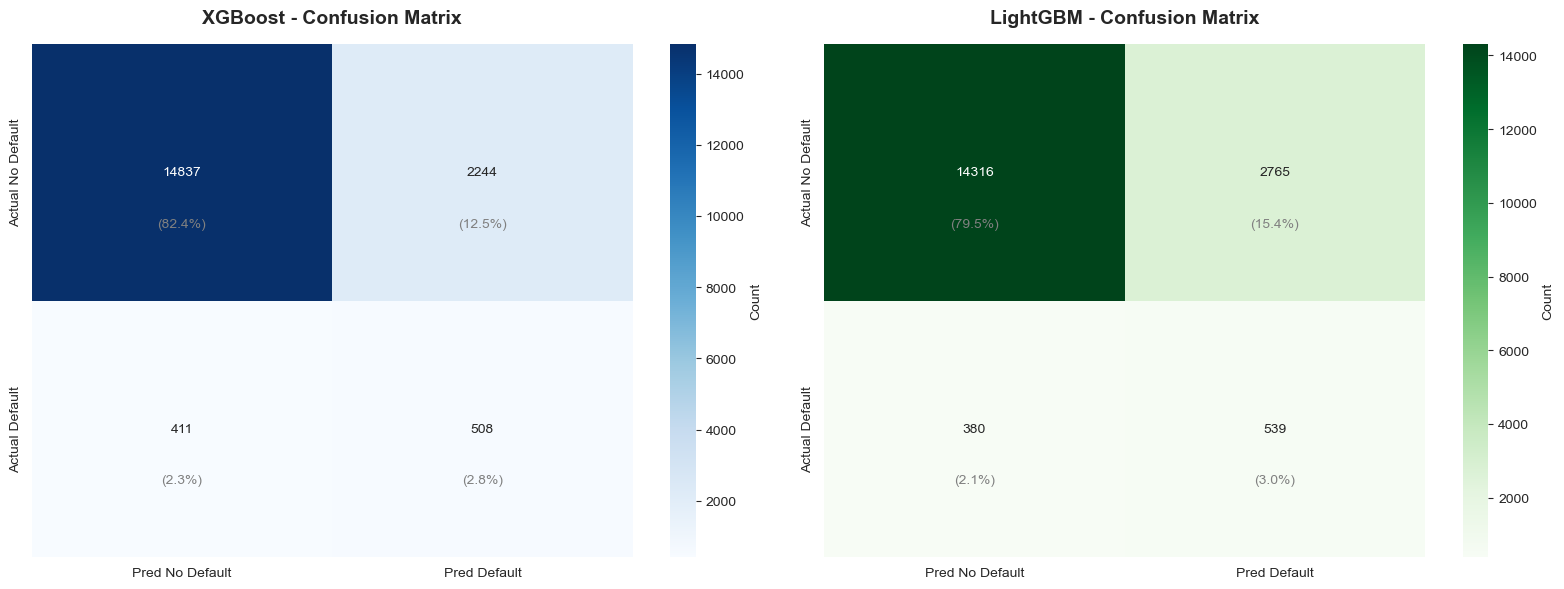

In [131]:
# Visualizations - Confusion Matrices
plot_confusion_matrices(results)
plt.show()

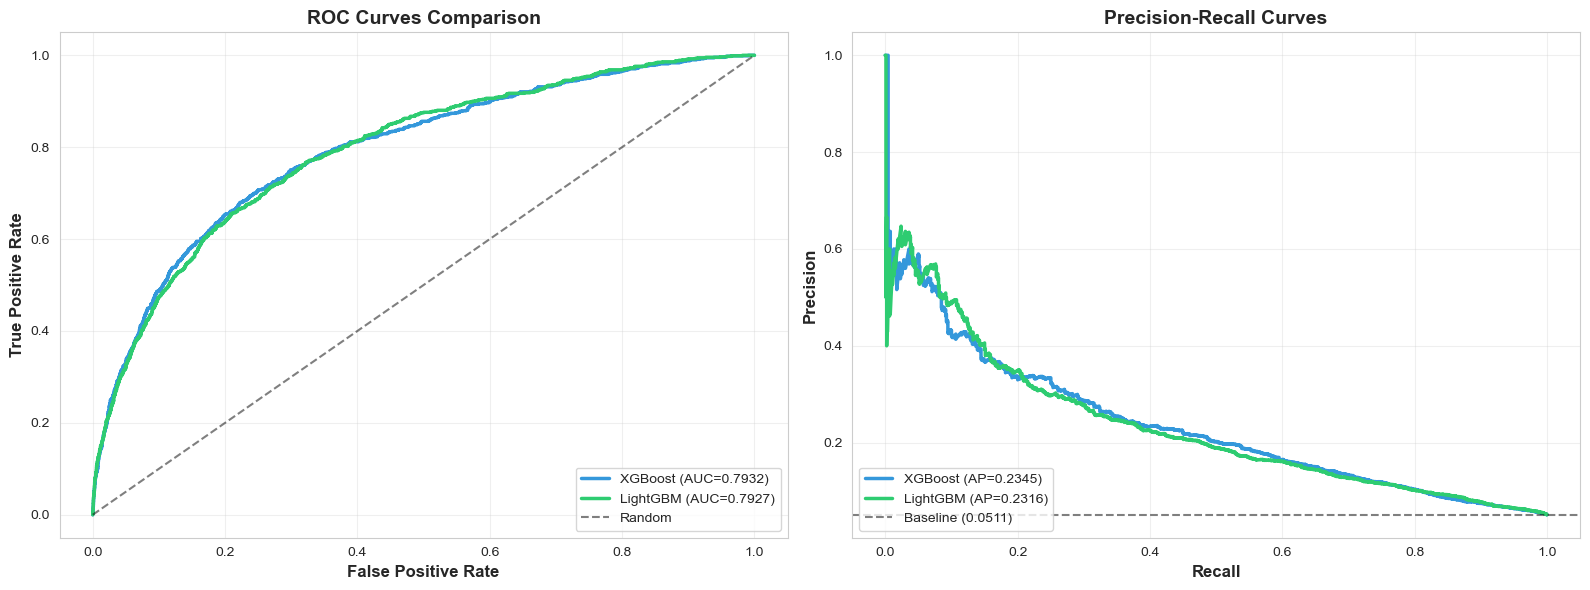

In [132]:
# Visualizations - ROC and PR Curves
plot_roc_pr_curves(results, y_test)
plt.show()

## 5. Feature Importance Analysis

In [133]:
# Get feature importance for all models
importance_dict = {}
for name, model in models.items():
    importance_dict[name] = get_feature_importance(model, X_train.columns, top_n=25)
    print(f"\n{name} - Top 20 Features:")
    print("="*60)
    print(importance_dict[name].head(20).to_string(index=False))


XGBoost - Top 20 Features:
                   Feature  Importance
    monthly_free_cash_flow    0.055069
credit_score_category_fair    0.042450
            monthly_income    0.029976
              credit_score    0.025907
          total_risk_score    0.023982
        debt_service_ratio    0.018069
                       age    0.017320
             annual_income    0.017088
      debt_to_income_ratio    0.015524
        loan_type_personal    0.014030
        high_interest_flag    0.013432
        num_public_records    0.012394
        recent_delinquency    0.012072
   payment_to_income_ratio    0.011134
                  state_NC    0.010408
          available_income    0.010355
     education_high_school    0.010346
                  state_MD    0.010344
       num_credit_accounts    0.009904
        credit_utilization    0.009705

LightGBM - Top 20 Features:
                      Feature  Importance
                 credit_score         317
           credit_utilization         20

In [134]:
# Compare feature importance across models
comparison_importance = compare_feature_importance(importance_dict)
 
print("\nTop 15 Features by Average Importance:")
print("="*70)
print(comparison_importance.head(15).to_string(index=False))


Top 15 Features by Average Importance:
                      Feature  XGBoost  LightGBM    Average
                 credit_score 0.025907     317.0 158.512954
           credit_utilization 0.009705     205.0 102.504853
       oldest_credit_line_age 0.000000     198.0  99.000000
               random_noise_1 0.000000     195.0  97.500000
                interest_rate 0.000000     183.0  91.500000
            employment_length 0.000000     181.0  90.500000
      account_diversity_index 0.000000     176.0  88.000000
marketing_campaign_target_enc 0.000000     172.0  86.000000
          credit_usage_amount 0.000000     163.0  81.500000
          num_credit_accounts 0.009904     159.0  79.504952
               payment_burden 0.000000     158.0  79.000000
       monthly_free_cash_flow 0.055069     155.0  77.527535
                          age 0.017320     155.0  77.508660
             available_credit 0.000000     154.0  77.000000
             available_income 0.010355     152.0  76.005177


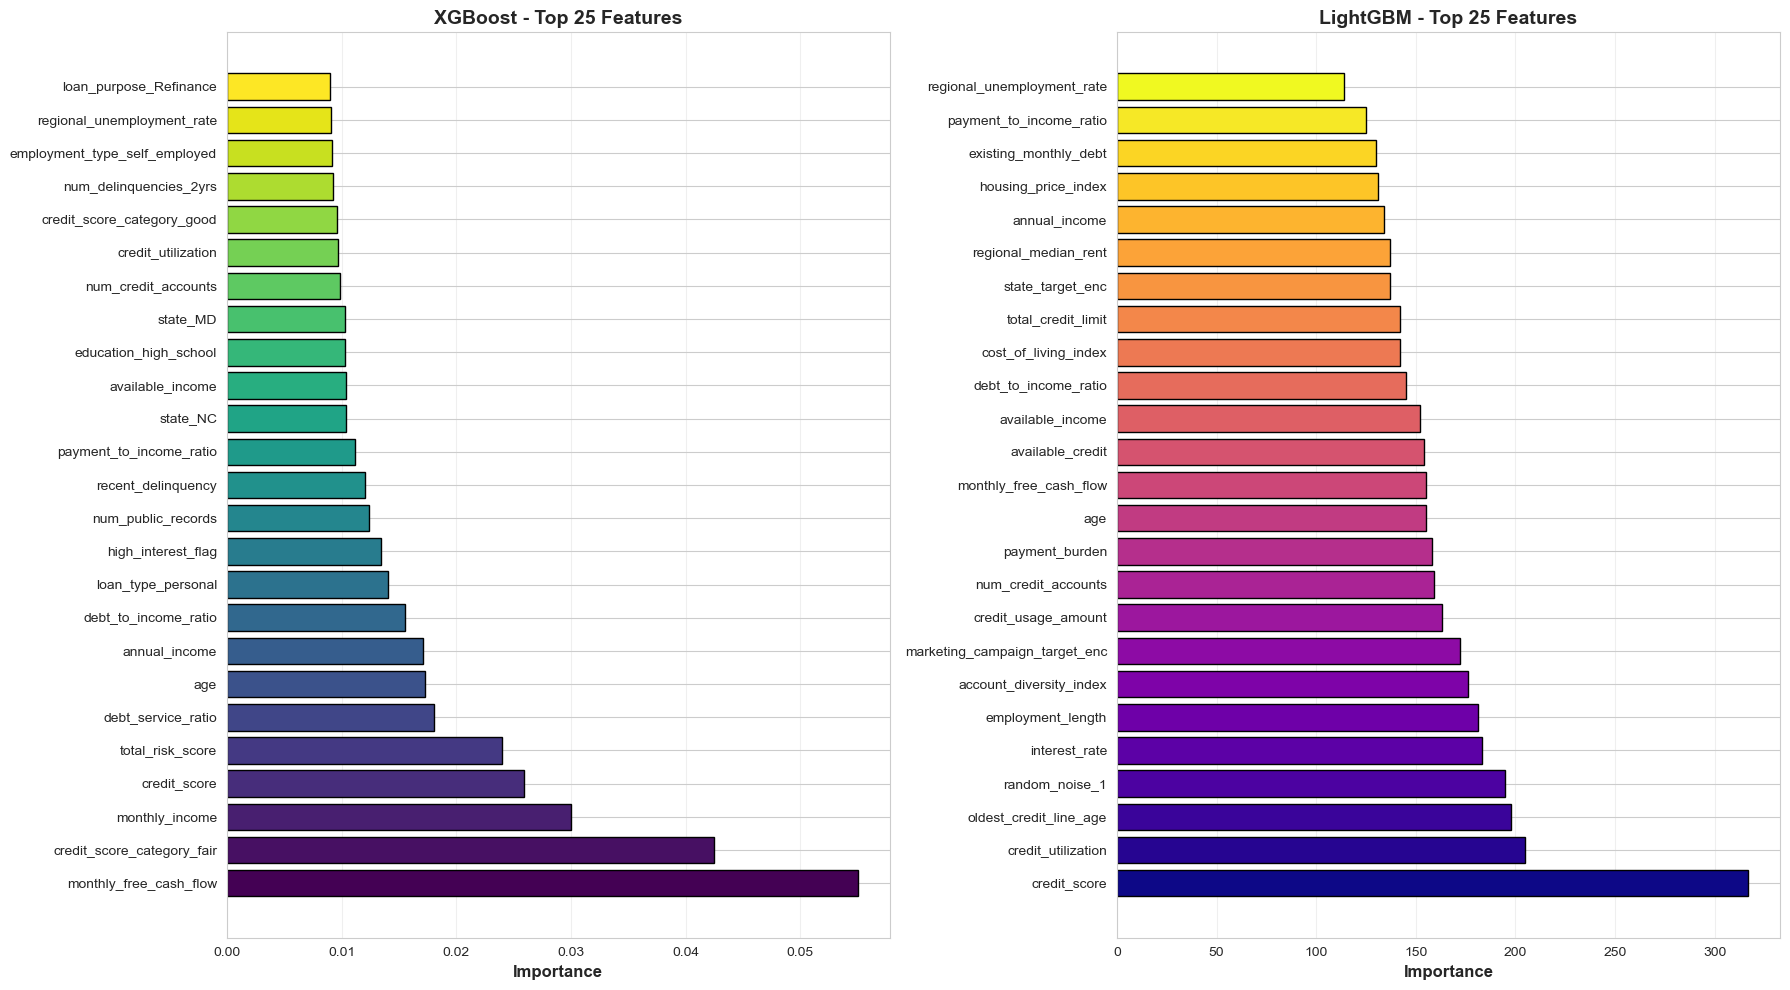

In [135]:
# Visualize side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

for ax, (name, imp_df) in zip(axes, importance_dict.items()):
    cmap = 'viridis' if name == 'XGBoost' else 'plasma'
    colors = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(imp_df)))
    ax.barh(range(len(imp_df)), imp_df['Importance'], color=colors, edgecolor='black')
    ax.set_yticks(range(len(imp_df)))
    ax.set_yticklabels(imp_df['Feature'])
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_title(f'{name} - Top 25 Features', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Hyperparameter Tuning 

In [ ]:
# Tune LightGBM (typically performs better after optimization)
print("Hyperparameter Tuning for LightGBM")
print("="*70)

param_distributions = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [10, 20, 30, 40],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

base_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

print("Starting RandomizedSearchCV (30 iterations, 5-fold CV)...\n")
start_time = time.time()

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)
elapsed = time.time() - start_time

print(f"\nCompleted in {elapsed/60:.1f} minutes")
print(f"\nBest Parameters:")
print("="*70)
for param, value in random_search.best_params_.items():
    print(f"  {param:<20s}: {value}")

print(f"\nBest CV ROC-AUC: {random_search.best_score_:.4f}")
print(f"Baseline ROC-AUC: {results[best_model_name]['test_auc']:.4f}")
print(f"Improvement: {random_search.best_score_ - results[best_model_name]['test_auc']:+.4f}")

lgb_optimized = random_search.best_estimator_

Hyperparameter Tuning for LightGBM
Starting RandomizedSearchCV (30 iterations, 5-fold CV)...

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
# Evaluate optimized model
results['LightGBM_Optimized'] = evaluate_model(
    lgb_optimized, X_train, X_test, y_train, y_test, 'LightGBM_Optimized'
)

print_model_metrics(results['LightGBM_Optimized'])

# Compare with baseline
baseline_auc = results['LightGBM']['test_auc']
optimized_auc = results['LightGBM_Optimized']['test_auc']
improvement = optimized_auc - baseline_auc

print(f"\n Optimization Impact:")
print(f"  Baseline:  {baseline_auc:.4f}")
print(f"  Optimized: {optimized_auc:.4f}")
print(f"  Gain:      {improvement:+.4f} ({(improvement/baseline_auc)*100:+.2f}%)")


LightGBM_Optimized Performance:
  Train ROC-AUC: 0.8339
  Test ROC-AUC:  0.8074
  Test PR-AUC:   0.2514
  Overfit Gap:   0.0264

  Confusion Matrix: TP=647 | FP=3,962 | FN=272 | TN=13,119

 Optimization Impact:
  Baseline:  0.7927
  Optimized: 0.8074
  Gain:      +0.0147 (+1.86%)


## 7. Feature Selection 

In [ ]:
# Get feature importance from optimized model
feature_importance_opt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb_optimized.feature_importances_
}).sort_values('Importance', ascending=False)

# Calculate cumulative importance
feature_importance_opt['Cumulative'] = (
    feature_importance_opt['Importance'].cumsum() / 
    feature_importance_opt['Importance'].sum()
)

# Select top features (95% threshold)
selected_features = feature_importance_opt[
    feature_importance_opt['Cumulative'] <= 0.95
]['Feature'].tolist()

print("Feature Selection Analysis")
print("="*70)
print(f"Total features: {len(X_train.columns)}")
print(f"Selected features (95% importance): {len(selected_features)}")
print(f"Features removed: {len(X_train.columns) - len(selected_features)}")

print(f"\nTop 15 Features:")
for idx, row in feature_importance_opt.head(15).iterrows():
    print(f"  {row['Feature']:35s} {row['Importance']:>8.1f} ({row['Cumulative']*100:>5.1f}%)")

Feature Selection Analysis
Total features: 111
Selected features (95% importance): 39
Features removed: 72

Top 15 Features:
  credit_score                           142.0 (  9.8%)
  credit_utilization                      97.0 ( 16.5%)
  age                                     78.0 ( 21.9%)
  debt_to_income_ratio                    72.0 ( 26.9%)
  num_credit_accounts                     72.0 ( 31.9%)
  interest_rate                           66.0 ( 36.5%)
  monthly_free_cash_flow                  60.0 ( 40.6%)
  payment_to_income_ratio                 50.0 ( 44.1%)
  available_income                        38.0 ( 46.7%)
  random_noise_1                          37.0 ( 49.3%)
  loan_purpose_target_enc                 35.0 ( 51.7%)
  num_public_records                      33.0 ( 54.0%)
  state_target_enc                        32.0 ( 56.2%)
  payment_burden                          32.0 ( 58.4%)
  total_risk_score                        32.0 ( 60.6%)
  credit_score                     

In [ ]:
# Test reduced model
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

print(f"\nTraining model with {len(selected_features)} features...")

lgb_reduced = lgb.LGBMClassifier(
    **random_search.best_params_,
    objective='binary',
    metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

lgb_reduced.fit(X_train_reduced, y_train)

# Evaluate
results['LightGBM_Reduced'] = evaluate_model(
    lgb_reduced, X_train_reduced, X_test_reduced, y_train, y_test, 'LightGBM_Reduced'
)

print_model_metrics(results['LightGBM_Reduced'])

# Comparison
full_auc = results['LightGBM_Optimized']['test_auc']
reduced_auc = results['LightGBM_Reduced']['test_auc']
diff = reduced_auc - full_auc

print(f"\n Feature Reduction Impact:")
print(f"  Full Model ({len(X_train.columns)} features):    {full_auc:.4f}")
print(f"  Reduced Model ({len(selected_features)} features): {reduced_auc:.4f}")
print(f"  Difference:                      {diff:+.4f}")

# Select final model
if reduced_auc >= full_auc - 0.005:
    print(f"\n Using reduced model (simpler with similar performance)")
    final_model = lgb_reduced
    final_features = selected_features
    final_result = results['LightGBM_Reduced']
else:
    print(f"\n Using full model (better performance)")
    final_model = lgb_optimized
    final_features = X_train.columns.tolist()
    final_result = results['LightGBM_Optimized']


Training model with 39 features...

LightGBM_Reduced Performance:
  Train ROC-AUC: 0.8338
  Test ROC-AUC:  0.8060
  Test PR-AUC:   0.2538
  Overfit Gap:   0.0278

  Confusion Matrix: TP=641 | FP=3,934 | FN=278 | TN=13,147

 Feature Reduction Impact:
  Full Model (111 features):    0.8074
  Reduced Model (39 features): 0.8060
  Difference:                      -0.0014

 Using reduced model (simpler with similar performance)

LightGBM_Reduced Performance:
  Train ROC-AUC: 0.8338
  Test ROC-AUC:  0.8060
  Test PR-AUC:   0.2538
  Overfit Gap:   0.0278

  Confusion Matrix: TP=641 | FP=3,934 | FN=278 | TN=13,147

 Feature Reduction Impact:
  Full Model (111 features):    0.8074
  Reduced Model (39 features): 0.8060
  Difference:                      -0.0014

 Using reduced model (simpler with similar performance)


## 8. Ensemble Methods (Stacking & Voting)

In [ ]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

print("Ensemble Models...")

# Stacking Ensemble
base_estimators = [
    ('xgb', models['XGBoost']),
    ('lgb', lgb_optimized)
]

stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1
)

print("\nTraining Stacking Ensemble...")
stacking_model.fit(X_train, y_train)
results['Stacking'] = evaluate_model(stacking_model, X_train, X_test, y_train, y_test, 'Stacking')
print_model_metrics(results['Stacking'])

# Voting Ensemble
voting_model = VotingClassifier(
    estimators=base_estimators,
    voting='soft',
    weights=[1, 2],  # More weight to optimized LightGBM
    n_jobs=-1
)

print("\nTraining Voting Ensemble...")
voting_model.fit(X_train, y_train)
results['Voting'] = evaluate_model(voting_model, X_train, X_test, y_train, y_test, 'Voting')
print_model_metrics(results['Voting'])

# Compare with best single model
print(f"\n Ensemble vs Single Model:")
print(f"  LightGBM Optimized: {results['LightGBM_Optimized']['test_auc']:.4f}")
print(f"  Stacking:           {results['Stacking']['test_auc']:.4f} ({results['Stacking']['test_auc'] - results['LightGBM_Optimized']['test_auc']:+.4f})")
print(f"  Voting:             {results['Voting']['test_auc']:.4f} ({results['Voting']['test_auc'] - results['LightGBM_Optimized']['test_auc']:+.4f})")

# Update final model if ensemble is better
best_ensemble = max([results['Stacking'], results['Voting']], key=lambda x: x['test_auc'])
if best_ensemble['test_auc'] > final_result['test_auc']:
    print(f"\n {best_ensemble['model_name']} selected as final model")
    final_model = stacking_model if best_ensemble['model_name'] == 'Stacking' else voting_model
    final_result = best_ensemble
    final_features = X_train.columns.tolist()  # Use all features for ensemble

Ensemble Models...

Training Stacking Ensemble...

Stacking Performance:
  Train ROC-AUC: 0.8518
  Test ROC-AUC:  0.8074
  Test PR-AUC:   0.2501
  Overfit Gap:   0.0445

  Confusion Matrix: TP=0 | FP=0 | FN=919 | TN=17,081

Training Voting Ensemble...

Stacking Performance:
  Train ROC-AUC: 0.8518
  Test ROC-AUC:  0.8074
  Test PR-AUC:   0.2501
  Overfit Gap:   0.0445

  Confusion Matrix: TP=0 | FP=0 | FN=919 | TN=17,081

Training Voting Ensemble...

Voting Performance:
  Train ROC-AUC: 0.9113
  Test ROC-AUC:  0.8048
  Test PR-AUC:   0.2424
  Overfit Gap:   0.1065

  Confusion Matrix: TP=585 | FP=3,073 | FN=334 | TN=14,008

 Ensemble vs Single Model:
  LightGBM Optimized: 0.8074
  Stacking:           0.8074 (-0.0001)
  Voting:             0.8048 (-0.0026)

 Stacking selected as final model

Voting Performance:
  Train ROC-AUC: 0.9113
  Test ROC-AUC:  0.8048
  Test PR-AUC:   0.2424
  Overfit Gap:   0.1065

  Confusion Matrix: TP=585 | FP=3,073 | FN=334 | TN=14,008

 Ensemble vs Single M

## 9. Final Model Comparison

In [ ]:
# Compare baseline vs optimized (using corrected thresholds)
print("\nBASELINE vs OPTIMIZED COMPARISON (with Optimal Thresholds)")
print("="*70)

# Recalculate baseline metrics with optimal threshold
baseline = results['LightGBM']
baseline_proba = baseline['test_proba']
baseline_threshold = np.percentile(baseline_proba, 100 * (1 - y_train.mean()))
baseline_pred_opt = (baseline_proba >= baseline_threshold).astype(int)
cm_baseline = confusion_matrix(y_test, baseline_pred_opt)
tn_base, fp_base, fn_base, tp_base = cm_baseline.ravel()

# Optimized model metrics (already calculated)
optimized = final_result
opt_proba = optimized['test_proba']
opt_threshold = np.percentile(opt_proba, 100 * (1 - y_train.mean()))
opt_pred_opt = (opt_proba >= opt_threshold).astype(int)
cm_opt = confusion_matrix(y_test, opt_pred_opt)
tn_opt, fp_opt, fn_opt, tp_opt = cm_opt.ravel()

# Create comparison table
comparison_data = {
    'Model': ['Baseline LightGBM', 'Optimized (Best)'],
    'Train_AUC': [f"{baseline['train_auc']:.4f}", f"{optimized['train_auc']:.4f}"],
    'Test_AUC': [f"{baseline['test_auc']:.4f}", f"{optimized['test_auc']:.4f}"],
    'Test_PR': [f"{baseline['test_pr']:.4f}", f"{optimized['test_pr']:.4f}"],
    'Overfit': [f"{baseline['overfit_gap']:.4f}", f"{optimized['overfit_gap']:.4f}"],
    'TP': [tp_base, tp_opt],
    'FN': [fn_base, fn_opt],
    'Precision': [f"{tp_base/(tp_base+fp_base):.4f}", f"{tp_opt/(tp_opt+fp_opt):.4f}"],
    'Recall': [f"{tp_base/(tp_base+fn_base):.4f}", f"{tp_opt/(tp_opt+fn_opt):.4f}"]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Calculate improvements
print(f"\n Key Improvements:")
print(f"  ROC-AUC:         {optimized['test_auc'] - baseline['test_auc']:+.4f} ({((optimized['test_auc'] - baseline['test_auc'])/baseline['test_auc'])*100:+.2f}%)")
print(f"  PR-AUC:          {optimized['test_pr'] - baseline['test_pr']:+.4f} ({((optimized['test_pr'] - baseline['test_pr'])/baseline['test_pr'])*100:+.2f}%)")
print(f"  Overfit Gap:     {baseline['overfit_gap'] - optimized['overfit_gap']:+.4f} (reduced by {((baseline['overfit_gap'] - optimized['overfit_gap'])/baseline['overfit_gap'])*100:.1f}%)")
print(f"  Defaults Caught: {tp_opt - tp_base:+d} (TP: {tp_base} → {tp_opt})")

# Fix wording for defaults missed
fn_improvement = fn_base - fn_opt
if fn_improvement >= 0:
    print(f"  Defaults Missed: {fn_improvement} fewer (FN: {fn_base} → {fn_opt})")
else:
    print(f"  Defaults Missed: {abs(fn_improvement)} more (FN: {fn_base} → {fn_opt})")

print(f"  Precision:       {(tp_opt/(tp_opt+fp_opt)) - (tp_base/(tp_base+fp_base)):+.4f}")
print(f"  Recall:          {(tp_opt/(tp_opt+fn_opt)) - (tp_base/(tp_base+fn_base)):+.4f}")
print(f"  Features:        {len(X_train.columns) - len(final_features)} fewer")

print(f"\n Note: Metrics use optimal threshold ({opt_threshold:.5f}) not default 0.5")

# Store comparison for visualization
comparison_results = {
    'Baseline': baseline,
    'Optimized': optimized
}


BASELINE vs OPTIMIZED COMPARISON (with Optimal Thresholds)
            Model Train_AUC Test_AUC Test_PR Overfit  TP  FN Precision Recall
Baseline LightGBM    0.9494   0.7927  0.2316  0.1567 263 656    0.2862 0.2862
 Optimized (Best)    0.8518   0.8074  0.2501  0.0445 265 654    0.2884 0.2884

 Key Improvements:
  ROC-AUC:         +0.0146 (+1.85%)
  PR-AUC:          +0.0185 (+7.97%)
  Overfit Gap:     +0.1122 (reduced by 71.6%)
  Defaults Caught: +2 (TP: 263 → 265)
  Defaults Missed: 2 fewer (FN: 656 → 654)
  Precision:       +0.0022
  Recall:          +0.0022
  Features:        0 fewer

 Note: Metrics use optimal threshold (0.21226) not default 0.5


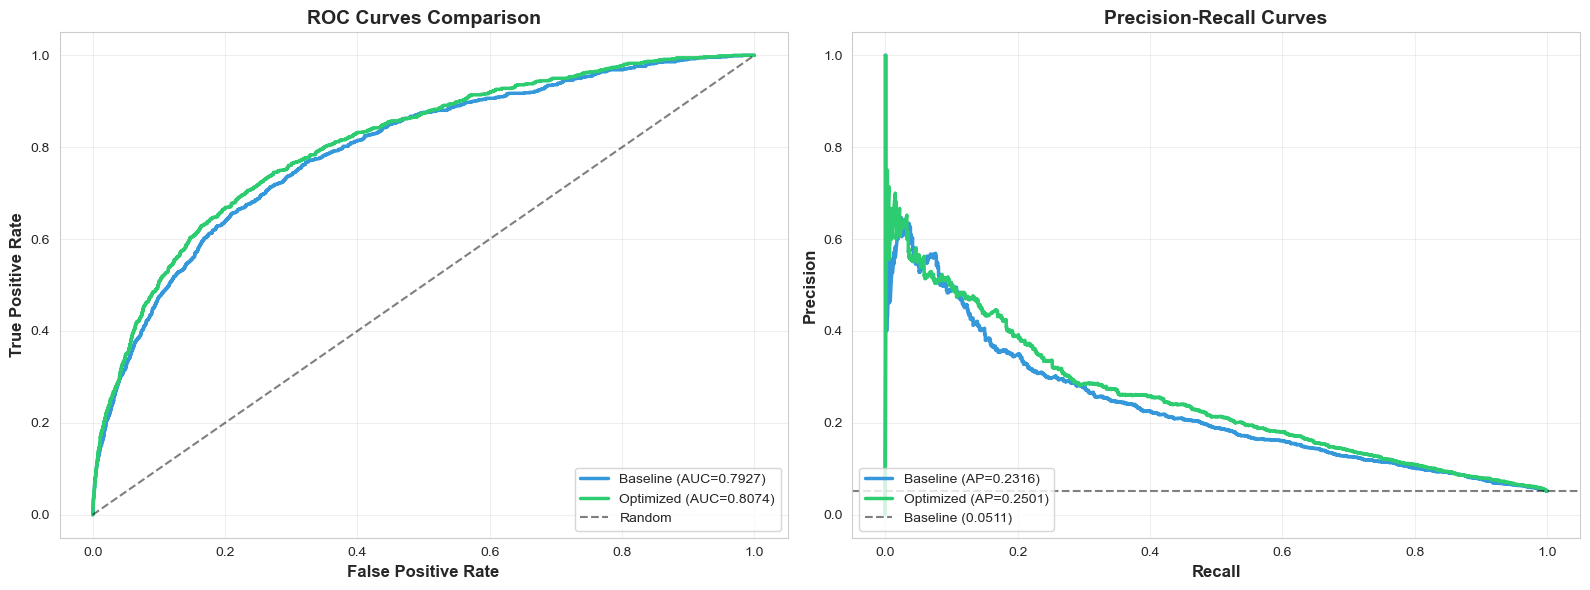

In [ ]:
# Visualize comparison
plot_roc_pr_curves(comparison_results, y_test)
plt.show()

## 11. Export Final Model

In [ ]:
# Handle both ensemble and tree-based models
if hasattr(final_model, 'feature_importances_'):
    # Tree-based model (LightGBM, XGBoost)
    feature_importance_final = pd.DataFrame({
        'Feature': final_features,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    model_type = final_result['model_name']
else:
    # Ensemble model (Stacking, Voting) - use base estimator
    print("Note: Ensemble model detected, using LightGBM base model for feature importance")
    base_lgb = lgb_optimized
    feature_importance_final = pd.DataFrame({
        'Feature': final_features,
        'Importance': base_lgb.feature_importances_
    }).sort_values('Importance', ascending=False)
    model_type = final_result['model_name']

feature_metadata = {
    'features': final_features,
    'n_features': len(final_features),
    'top_20_importance': feature_importance_final.head(20).to_dict('records')
}

metrics_data = {
    'model_type': model_type,
    'optimization': 'RandomizedSearchCV + Ensemble/Feature Selection',
    'test_roc_auc': float(final_result['test_auc']),
    'test_pr_auc': float(final_result['test_pr']),
    'train_roc_auc': float(final_result['train_auc']),
    'overfit_gap': float(final_result['overfit_gap']),
    'n_features': len(final_features),
    'confusion_matrix': {
        'true_negatives': int(final_result['tn']),
        'false_positives': int(final_result['fp']),
        'false_negatives': int(final_result['fn']),
        'true_positives': int(final_result['tp'])
    },
    'precision': float(final_result['tp'] / (final_result['tp'] + final_result['fp'])),
    'recall': float(final_result['tp'] / (final_result['tp'] + final_result['fn'])),
    'best_parameters': random_search.best_params_,
    'scale_pos_weight': float(scale_pos_weight)
}

# Export
print("Exporting Final Model Assets...")
print("="*70)

files = export_model_assets(
    final_model,
    feature_metadata,
    metrics_data,
    base_filename='final_lgbm_optimized'
)

for file in files:
    print(f" Created: {file}")



Note: Ensemble model detected, using LightGBM base model for feature importance
Exporting Final Model Assets...
 Created: final_lgbm_optimized.pkl
 Created: final_lgbm_optimized_features.json
 Created: final_lgbm_optimized_metrics.json
